Files already downloaded and verified
Samples per class (long-tail): [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Files already downloaded and verified


/home/zhu.3723/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zhu.3723/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1/100] Loss: 2.2332
[2/100] Loss: 1.3972
[3/100] Loss: 1.2191
[4/100] Loss: 1.0640
[5/100] Loss: 0.9668
[6/100] Loss: 0.9112
[7/100] Loss: 0.8628
[8/100] Loss: 0.8126
[9/100] Loss: 0.7848
[10/100] Loss: 0.7248
[11/100] Loss: 0.6900
[12/100] Loss: 0.6443
[13/100] Loss: 0.5988
[14/100] Loss: 0.5556
[15/100] Loss: 0.4979
[16/100] Loss: 0.4382
[17/100] Loss: 0.3840
[18/100] Loss: 0.3143
[19/100] Loss: 0.2901
[20/100] Loss: 0.1995
[21/100] Loss: 0.2061
[22/100] Loss: 0.1511
[23/100] Loss: 0.0970
[24/100] Loss: 0.0861
[25/100] Loss: 0.0888
[26/100] Loss: 0.0752
[27/100] Loss: 0.0850
[28/100] Loss: 0.0872
[29/100] Loss: 0.0436
[30/100] Loss: 0.0353
[31/100] Loss: 0.0237
[32/100] Loss: 0.0186
[33/100] Loss: 0.0142
[34/100] Loss: 0.0158
[35/100] Loss: 0.0288
[36/100] Loss: 0.0590
[37/100] Loss: 0.1069
[38/100] Loss: 0.0661
[39/100] Loss: 0.0477
[40/100] Loss: 0.0210
[41/100] Loss: 0.0087
[42/100] Loss: 0.0042
[43/100] Loss: 0.0013
[44/100] Loss: 0.0009
[45/100] Loss: 0.0011
[46/100] Loss: 0.00

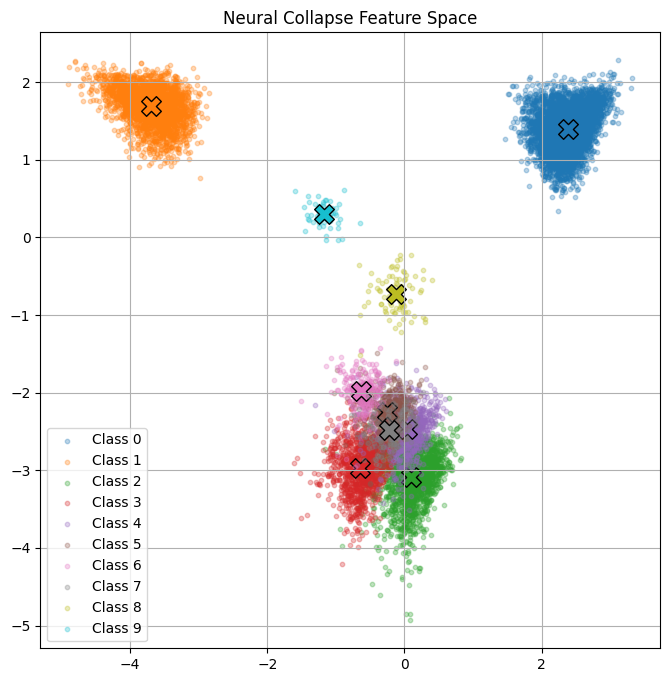

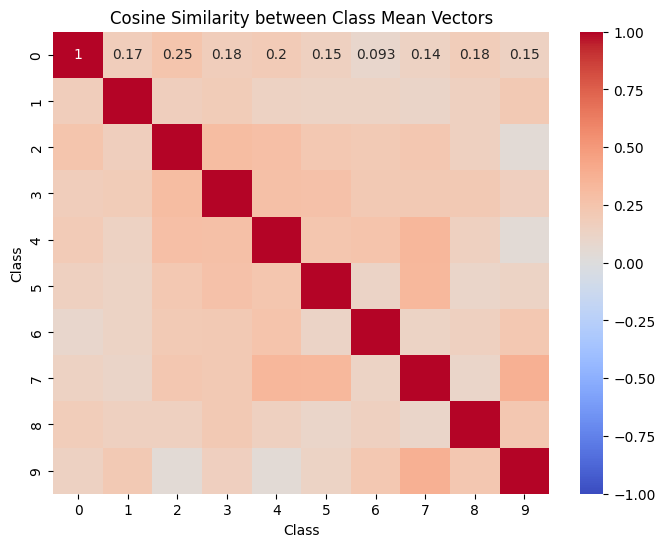

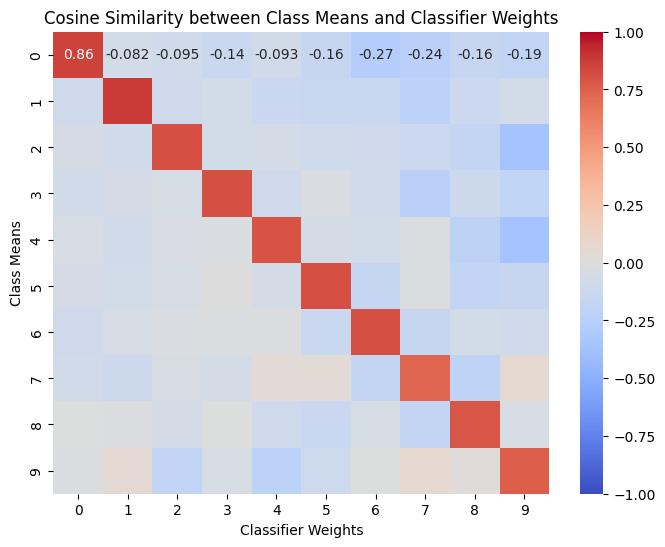

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import numpy as np
from collections import defaultdict
from torch.utils.data import Subset

def create_long_tail_dataset(dataset, num_classes=10, imbalance_ratio=100):
    """
    Create a long-tailed version of the dataset with imbalance ratio.
    imbalance_ratio = max_class_samples / min_class_samples
    """
    img_num_per_class = []

    # Use exponential decay to simulate long-tail
    max_num = len(dataset) / num_classes
    for cls_idx in range(num_classes):
        num = max_num * (imbalance_ratio ** (-cls_idx / (num_classes - 1)))
        img_num_per_class.append(int(num))

    print("Samples per class (long-tail):", img_num_per_class)

    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for cls, num in enumerate(img_num_per_class):
        indices = class_indices[cls]
        np.random.shuffle(indices)
        selected_indices += indices[:num]

    return Subset(dataset, selected_indices)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set = create_long_tail_dataset(full_train_set, num_classes=10, imbalance_ratio=100)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)


class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = resnet18(pretrained=False, num_classes=num_classes)
        self.features = None

        # Replace first conv for CIFAR-10
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()

        # Register a hook on the penultimate layer
        self.model.avgpool.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        self.features = output.view(output.size(0), -1)

    def forward(self, x):
        out = self.model(x)
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNetFeatureExtractor().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

def train(net, epochs=50):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        print(f"[{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

train(net, epochs=100)

torch.save(net.state_dict(), 'resnet_feature_extractor.pth')
@torch.no_grad()
def extract_features(net, dataloader):
    net.eval()
    all_features = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        _ = net(inputs)
        feats = net.features.cpu()
        all_features.append(feats)
        all_labels.append(labels)

    features = torch.cat(all_features, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return features, labels

features, labels = extract_features(net, train_loader)

# Compute class means
class_means = []
for i in range(10):
    class_feat = features[labels == i]
    class_mean = class_feat.mean(dim=0)
    class_means.append(class_mean)

class_means = torch.stack(class_means)


def plot_feature_collapse(features, labels, class_means):
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features.numpy())
    means_2d = pca.transform(class_means.numpy())

    plt.figure(figsize=(8, 8))
    palette = sns.color_palette("tab10", 10)
    for i in range(10):
        idx = (labels == i).numpy()
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {i}", alpha=0.3, s=10, color=palette[i])
        plt.scatter(means_2d[i, 0], means_2d[i, 1], marker='X', s=200, edgecolors='k', color=palette[i])

    plt.title("Neural Collapse Feature Space")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_feature_collapse(features, labels, class_means)




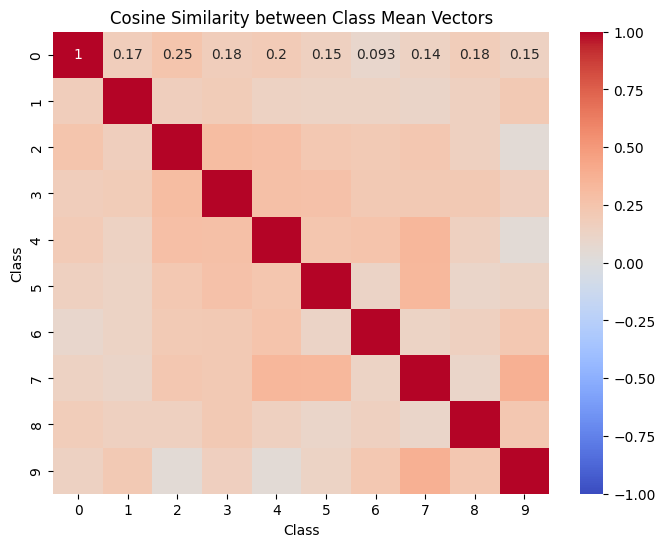

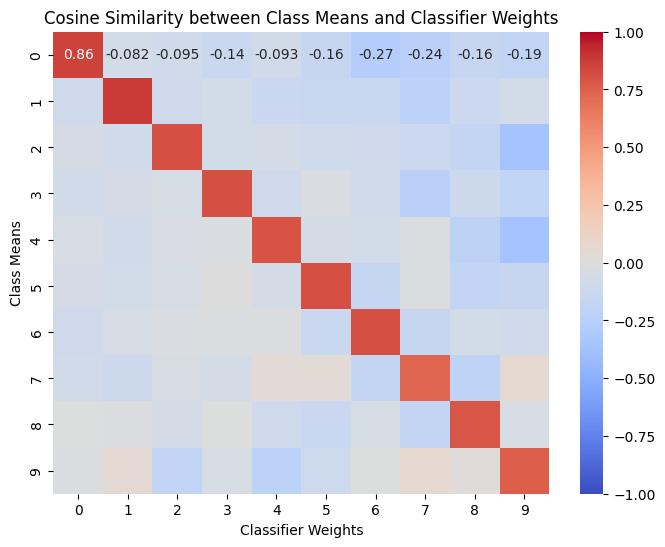

Cosine similarity matrix between class means and classifier weights:
[[ 0.8567 -0.0819 -0.0954 -0.1357 -0.0928 -0.1586 -0.2712 -0.2375 -0.1565
  -0.19  ]
 [-0.1018  0.875  -0.1088 -0.0816 -0.1416 -0.1512 -0.1399 -0.2261 -0.13
  -0.0849]
 [-0.0555 -0.0975  0.8101 -0.0821 -0.0768 -0.0953 -0.1071 -0.132  -0.1769
  -0.3634]
 [-0.0919 -0.064  -0.0493  0.8119 -0.1043 -0.0289 -0.0965 -0.2366 -0.1215
  -0.2005]
 [-0.0517 -0.093  -0.0387 -0.0293  0.7897 -0.0586 -0.0798 -0.0158 -0.2124
  -0.3622]
 [-0.0678 -0.0823 -0.053   0.0006 -0.0742  0.818  -0.1684 -0.0119 -0.1813
  -0.1572]
 [-0.1049 -0.0524 -0.0306 -0.0179 -0.0101 -0.1404  0.8087 -0.1577 -0.0844
  -0.094 ]
 [-0.0859 -0.1187 -0.0394 -0.0748  0.0337  0.0455 -0.1745  0.7284 -0.2058
   0.0645]
 [-0.0039 -0.0125 -0.0632 -0.0075 -0.1088 -0.1479 -0.0543 -0.1791  0.7837
  -0.0438]
 [-0.0181  0.0553 -0.1883 -0.0545 -0.2259 -0.1098 -0.0044  0.0724  0.0249
   0.7503]]


In [ ]:
import torch.nn.functional as F

# Normalize class means
normalized_means = F.normalize(class_means, p=2, dim=1)  # [10, D]

# Compute cosine similarity matrix
cos_sim_matrix = torch.matmul(normalized_means, normalized_means.T)  # [10, 10]

# Convert to numpy for visualization
cos_sim_np = cos_sim_matrix.cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cos_sim_np, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Cosine Similarity between Class Mean Vectors")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()


weights = net.model.fc.weight.data  

device = next(net.parameters()).device

means_norm = F.normalize(class_means.to(device), p=2, dim=1)
weights_norm = F.normalize(net.model.fc.weight.data.to(device), p=2, dim=1)


sim_matrix = torch.matmul(means_norm, weights_norm.T)



plt.figure(figsize=(8, 6))
# print all value in the matrix
sns.heatmap(sim_matrix.cpu().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)


plt.title("Cosine Similarity between Class Means and Classifier Weights")
plt.xlabel("Classifier Weights")
plt.ylabel("Class Means")
plt.show()

# 确保都在同一设备
device = next(net.parameters()).device
means_norm = F.normalize(class_means.to(device), p=2, dim=1)
weights_norm = F.normalize(net.model.fc.weight.data.to(device), p=2, dim=1)
# features * class 
# 计算余弦相似度
sim_matrix = torch.matmul(means_norm, weights_norm.T)

# 打印所有值（保留小数点后4位）
np.set_printoptions(precision=4, suppress=True)
print("Cosine similarity matrix between class means and classifier weights:")
print(sim_matrix.cpu().numpy())
# 

Files already downloaded and verified
Files already downloaded and verified


/home/zhu.3723/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zhu.3723/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1/100] Loss: 1.8008
[2/100] Loss: 1.2134
[3/100] Loss: 0.8964
[4/100] Loss: 0.6909
[5/100] Loss: 0.5461
[6/100] Loss: 0.4641
[7/100] Loss: 0.3958
[8/100] Loss: 0.3467
[9/100] Loss: 0.3228
[10/100] Loss: 0.2929
[11/100] Loss: 0.2674
[12/100] Loss: 0.2435
[13/100] Loss: 0.2312
[14/100] Loss: 0.2199
[15/100] Loss: 0.2099
[16/100] Loss: 0.1974
[17/100] Loss: 0.1872
[18/100] Loss: 0.1880
[19/100] Loss: 0.1796
[20/100] Loss: 0.1708
[21/100] Loss: 0.1674
[22/100] Loss: 0.1695
[23/100] Loss: 0.1605
[24/100] Loss: 0.1528
[25/100] Loss: 0.1550
[26/100] Loss: 0.1594
[27/100] Loss: 0.1452
[28/100] Loss: 0.1340
[29/100] Loss: 0.1394
[30/100] Loss: 0.1306
[31/100] Loss: 0.1320
[32/100] Loss: 0.1251
[33/100] Loss: 0.1281
[34/100] Loss: 0.1088
[35/100] Loss: 0.1211
[36/100] Loss: 0.1190
[37/100] Loss: 0.1017
[38/100] Loss: 0.1060
[39/100] Loss: 0.1091
[40/100] Loss: 0.0949
[41/100] Loss: 0.0901
[42/100] Loss: 0.0989
[43/100] Loss: 0.1007
[44/100] Loss: 0.0742
[45/100] Loss: 0.0834
[46/100] Loss: 0.08

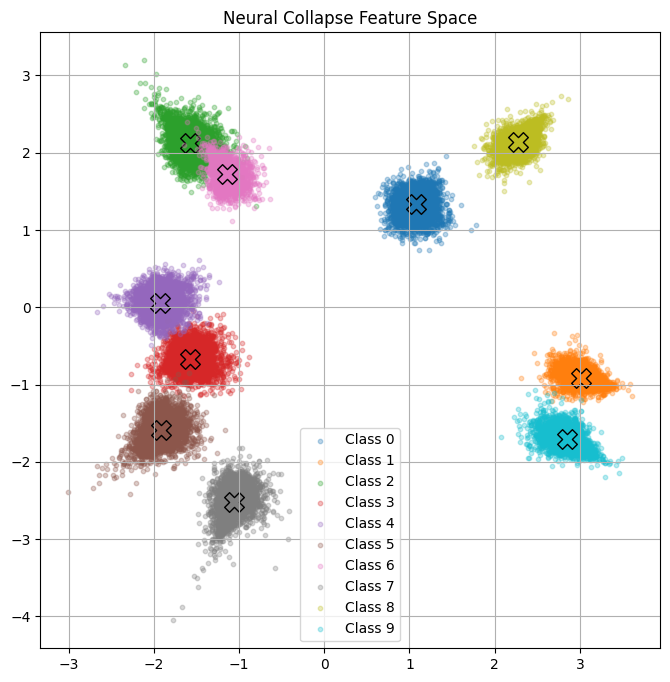

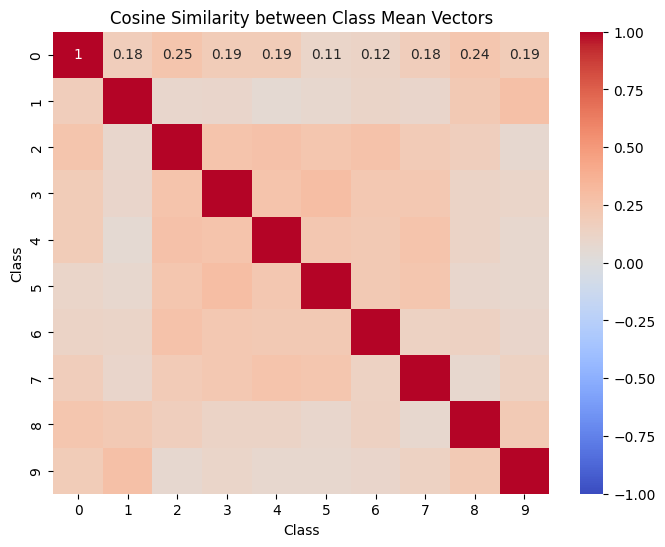

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import numpy as np
from collections import defaultdict
from torch.utils.data import Subset

def create_long_tail_dataset(dataset, num_classes=10, imbalance_ratio=100):
    """
    Create a long-tailed version of the dataset with imbalance ratio.
    imbalance_ratio = max_class_samples / min_class_samples
    """
    img_num_per_class = []

    # Use exponential decay to simulate long-tail
    max_num = len(dataset) / num_classes
    for cls_idx in range(num_classes):
        num = max_num * (imbalance_ratio ** (-cls_idx / (num_classes - 1)))
        img_num_per_class.append(int(num))

    print("Samples per class (long-tail):", img_num_per_class)

    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for cls, num in enumerate(img_num_per_class):
        indices = class_indices[cls]
        np.random.shuffle(indices)
        selected_indices += indices[:num]

    return Subset(dataset, selected_indices)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_set = create_long_tail_dataset(full_train_set, num_classes=10, imbalance_ratio=100)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)


class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = resnet18(pretrained=False, num_classes=num_classes)
        self.features = None

        # Replace first conv for CIFAR-10
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()

        # Register a hook on the penultimate layer
        self.model.avgpool.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        self.features = output.view(output.size(0), -1)

    def forward(self, x):
        out = self.model(x)
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNetFeatureExtractor().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

def train(net, epochs=50):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        print(f"[{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

train(net, epochs=100)

torch.save(net.state_dict(), 'resnet_balanced.pth')

@torch.no_grad()
def extract_features(net, dataloader):
    net.eval()
    all_features = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        _ = net(inputs)
        feats = net.features.cpu()
        all_features.append(feats)
        all_labels.append(labels)

    features = torch.cat(all_features, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return features, labels

features, labels = extract_features(net, train_loader)

# Compute class means
class_means = []
for i in range(10):
    class_feat = features[labels == i]
    class_mean = class_feat.mean(dim=0)
    class_means.append(class_mean)

class_means = torch.stack(class_means)


def plot_feature_collapse(features, labels, class_means):
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features.numpy())
    means_2d = pca.transform(class_means.numpy())

    plt.figure(figsize=(8, 8))
    palette = sns.color_palette("tab10", 10)
    for i in range(10):
        idx = (labels == i).numpy()
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {i}", alpha=0.3, s=10, color=palette[i])
        plt.scatter(means_2d[i, 0], means_2d[i, 1], marker='X', s=200, edgecolors='k', color=palette[i])

    plt.title("Neural Collapse Feature Space")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_feature_collapse(features, labels, class_means)

import torch.nn.functional as F

# Normalize class means
normalized_means = F.normalize(class_means, p=2, dim=1)  # [10, D]

# Compute cosine similarity matrix
cos_sim_matrix = torch.matmul(normalized_means, normalized_means.T)  # [10, 10]

# Convert to numpy for visualization
cos_sim_np = cos_sim_matrix.cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cos_sim_np, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Cosine Similarity between Class Mean Vectors")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

weights = net.model.fc.weight.data  

device = next(net.parameters()).device


means_norm = F.normalize(class_means.to(device), p=2, dim=1)
weights_norm = F.normalize(net.model.fc.weight.data.to(device), p=2, dim=1)


sim_matrix = torch.matmul(means_norm, weights_norm.T)



plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix.cpu().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Cosine Similarity between Class Means and Classifier Weights")
plt.xlabel("Classifier Weights")
plt.ylabel("Class Means")
plt.show()




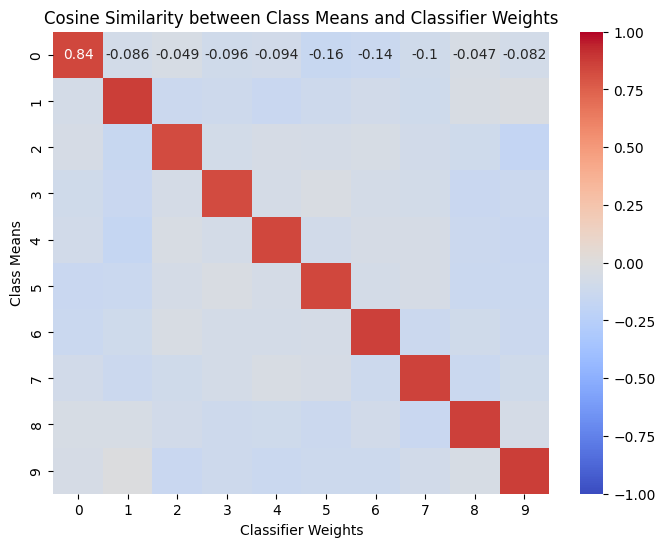

In [4]:
# 提取分类器权重（shape: [num_classes, feature_dim]）
weights = net.model.fc.weight.data  # 注意是最后一层的全连接权重

# 获取模型所在设备
device = next(net.parameters()).device

# 确保 class_means 和 weights 都在同一个设备
means_norm = F.normalize(class_means.to(device), p=2, dim=1)
weights_norm = F.normalize(net.model.fc.weight.data.to(device), p=2, dim=1)

# 计算相似度
sim_matrix = torch.matmul(means_norm, weights_norm.T)


# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix.cpu().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Cosine Similarity between Class Means and Classifier Weights")
plt.xlabel("Classifier Weights")
plt.ylabel("Class Means")
plt.show()
